## Install required libraries

In [1]:
!pip install obonet networkx

In [2]:
!pip install duckdb --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
!pip install polars --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg

Looking in links: /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
Looking in links: /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg


In [3]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 48.1 MB/s eta 0:00:00a 0:00:01


## Import required modules

In [4]:
import numpy as np
import pandas as pd
import os
import duckdb as dd
import polars as pl
import h5py
import networkx as nx
import obonet as ob

import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO

## Separating out the GO terms based on Ontology roots

In [5]:
def separate_go_terms_by_namespace(graph):
    """
    Separates GO terms from a networkx graph into BP, CC, and MF categories.

    Args:
        graph: A networkx MultiDiGraph loaded with obonet.

    Returns:
        A dictionary containing lists of GO term IDs for each namespace.
    """
    bp_terms = []
    cc_terms = []
    mf_terms = []

    # Iterate through every node in the graph, accessing its ID (node_id) and attributes (data)
    for node_id, data in graph.nodes(data=True):
        # The namespace is stored in the 'namespace' key of the node's data dictionary
        namespace = data.get('namespace')

        if namespace == 'biological_process':
            bp_terms.append(node_id)
        elif namespace == 'cellular_component':
            cc_terms.append(node_id)
        elif namespace == 'molecular_function':
            mf_terms.append(node_id)

    return {
        'BP': bp_terms,
        'CC': cc_terms,
        'MF': mf_terms
    }

## Load the Gene Ontology (GO) basic OBO file from the OBO Library

In [6]:
go_file_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo'
print(f"Loading Gene Ontology from {go_file_path}...")
go_graph = ob.read_obo(go_file_path)
print(f"Total terms loaded: {len(go_graph)}")

Loading Gene Ontology from /kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo...
Total terms loaded: 40122


## Separate the terms

In [7]:
separated_terms = separate_go_terms_by_namespace(go_graph)

In [8]:
print("\nGO Term Counts by Namespace:")
print(f"Biological Process (BP): {len(separated_terms['BP'])} terms")
print(f"Cellular Component (CC): {len(separated_terms['CC'])} terms")
print(f"Molecular Function (MF): {len(separated_terms['MF'])} terms")

print("\nFirst 5 Cellular Component (CC) terms:")
for term_id in separated_terms['CC'][:5]:
    # You can get the human-readable name using the graph data dictionary
    name = go_graph.nodes[term_id].get('name')
    print(f"- {term_id}: {name}")


GO Term Counts by Namespace:
Biological Process (BP): 25950 terms
Cellular Component (CC): 4041 terms
Molecular Function (MF): 10131 terms

First 5 Cellular Component (CC) terms:
- GO:0000015: phosphopyruvate hydratase complex
- GO:0000109: nucleotide-excision repair complex
- GO:0000110: nucleotide-excision repair factor 1 complex
- GO:0000111: nucleotide-excision repair factor 2 complex
- GO:0000112: nucleotide-excision repair factor 3 complex


In [18]:
go_graph_edges = list(go_graph.edges)

print(go_graph_edges[0])
print(go_graph.nodes["GO:0008150"])
print("*************")
print(go_graph.nodes["GO:0005575"])
print("*************")
print(go_graph.nodes["GO:0003674"])

('GO:0000001', 'GO:0048308', 'is_a')
{'name': 'biological_process', 'namespace': 'biological_process', 'alt_id': ['GO:0000004', 'GO:0007582', 'GO:0044699'], 'def': '"A biological process is the execution of a genetically-encoded biological module or program. It consists of all the steps required to achieve the specific biological objective of the module. A biological process is accomplished by a particular set of molecular functions carried out by specific gene products (or macromolecular complexes), often in a highly regulated manner and in a particular temporal sequence." [GOC:pdt]', 'comment': "Note that, in addition to forming the root of the biological process ontology, this term is recommended for the annotation of gene products whose biological process is unknown. When this term is used for annotation, it indicates that no information was available about the biological process of the gene product annotated as of the date the annotation was made; the evidence code 'no data' (ND),

In [37]:
id_to_name = {id_: data.get("name") for id_, data in go_graph.nodes(data=True)}

name_to_id = {
    data["name"]: id_ for id_, data in go_graph.nodes(data=True) if "name" in data
}

print("id_to_name['GO:0008150'] -> ", id_to_name['GO:0008150'])
print("name_to_id['cellular_component'] -> ", name_to_id['cellular_component'])

id_to_name['GO:0008150'] ->  biological_process
name_to_id['cellular_component'] ->  GO:0005575


In [38]:
# Find edges to parent terms
node = name_to_id["cellular_component"]
for child, parent, key in go_graph.out_edges(node, keys=True):
    print(f"• {id_to_name[child]} ⟶ {key} ⟶ {id_to_name[parent]}")

In [50]:
# Find edges to children terms
node = name_to_id["cellular_component"]
for child, parent, key in go_graph.in_edges(node, keys=True):
    print(f"• {id_to_name[parent]} ⟵ {key} ⟵ {id_to_name[child]}")
print("**********************")
node = name_to_id["biological_process"]
for child, parent, key in go_graph.in_edges(node, keys=True):
    print(f"• {id_to_name[parent]} ⟵ {key} ⟵ {id_to_name[child]}")
print("**********************")
node = name_to_id["molecular_function"]
for child, parent, key in go_graph.in_edges(node, keys=True):
    print(f"• {id_to_name[parent]} ⟵ {key} ⟵ {id_to_name[child]}")

• cellular_component ⟵ is_a ⟵ protein-containing complex
• cellular_component ⟵ is_a ⟵ virion component
• cellular_component ⟵ is_a ⟵ cellular anatomical structure
**********************
• biological_process ⟵ is_a ⟵ immune system process
• biological_process ⟵ is_a ⟵ cellular process
• biological_process ⟵ is_a ⟵ viral process
• biological_process ⟵ is_a ⟵ reproductive process
• biological_process ⟵ is_a ⟵ multicellular organismal process
• biological_process ⟵ is_a ⟵ developmental process
• biological_process ⟵ is_a ⟵ growth
• biological_process ⟵ is_a ⟵ locomotion
• biological_process ⟵ is_a ⟵ homeostatic process
• biological_process ⟵ is_a ⟵ pigmentation
• biological_process ⟵ is_a ⟵ biological process involved in interspecies interaction between organisms
• biological_process ⟵ is_a ⟵ biological phase
• biological_process ⟵ is_a ⟵ rhythmic process
• biological_process ⟵ positively_regulates ⟵ positive regulation of biological process
• biological_process ⟵ negatively_regulates ⟵ n

In [51]:
# Find edges to children terms
node = name_to_id["cellular_component"]
for child, parent, key in go_graph.in_edges(node, keys=True):
    print(f"{parent} ⟵ {key} ⟵ {child}")
    while child:
        print(f"{parent} ⟵ {key} ⟵ {child}")

GO:0005575 ⟵ is_a ⟵ GO:0032991
GO:0005575 ⟵ is_a ⟵ GO:0044423
GO:0005575 ⟵ is_a ⟵ GO:0110165


In [47]:
go_graph.in_edges(node, keys=True)

InMultiEdgeDataView([('GO:0032991', 'GO:0005575', 'is_a'), ('GO:0044423', 'GO:0005575', 'is_a'), ('GO:0110165', 'GO:0005575', 'is_a')])

In [48]:
go_graph.out_edges(node, keys=True)

OutMultiEdgeDataView([])

## Introduce the ESM2 embeddings of dimension 480

In [9]:
emb_df = pl.read_parquet('/kaggle/input/cafa6-protein-go-terms-feat-labels/train_protein_features_esm2_480.parquet')
emb_df.shape

(82404, 2)

In [10]:
emb_df.head(5)

protein_accession_id,embedding_arrays
str,"array[f32, 480]"
"""Q8H2B4""","[-0.155396, -0.092102, … 0.036743]"
"""O01836""","[-0.121338, 0.071411, … 0.01651]"
"""Q13309""","[-0.148682, 0.137695, … -0.005337]"
"""Q9UPW5""","[-0.016464, -0.000262, … 0.102783]"
"""P70453""","[-0.175415, 0.082336, … -0.007427]"


In [11]:
dd.sql(" select count(distinct(protein_accession_id)) as proteins from emb_df ").pl()

proteins
i64
82404


## Bring in the training data; proteins and the corresponding GO terms

In [12]:
train_terms_df = pl.read_csv('/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv', separator='\t')
train_terms_df.shape

(537027, 3)

In [13]:
train_terms_df.filter(pl.col('term') == 'GO:0000322')

EntryID,term,aspect
str,str,str
"""P60766""","""GO:0000322""","""C"""
"""P70452""","""GO:0000322""","""C"""
"""Q39649""","""GO:0000322""","""C"""
"""Q9ES28""","""GO:0000322""","""C"""
"""P63044""","""GO:0000322""","""C"""


In [14]:
dd.sql(" select count(distinct(EntryID)) as proteins from train_terms_df ").pl()

proteins
i64
82404


## Introduce the embeddings into the training data

In [15]:
train_terms_w_embeds = dd.sql("select distinct t1.protein_accession_id, t2.term, t2.aspect \
, t1.embedding_arrays as protein_embedding \
from emb_df t1 \
join train_terms_df t2 \
on t1.protein_accession_id = t2.EntryID").pl()

print(train_terms_w_embeds.shape)
print(train_terms_w_embeds.filter(pl.col('term') == 'GO:0000322'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(537027, 4)
shape: (5, 4)
┌──────────────────────┬────────────┬────────┬─────────────────────────────────┐
│ protein_accession_id ┆ term       ┆ aspect ┆ protein_embedding               │
│ ---                  ┆ ---        ┆ ---    ┆ ---                             │
│ str                  ┆ str        ┆ str    ┆ array[f32, 480]                 │
╞══════════════════════╪════════════╪════════╪═════════════════════════════════╡
│ Q9ES28               ┆ GO:0000322 ┆ C      ┆ [-0.102844, -0.062439, … -0.04… │
│ P70452               ┆ GO:0000322 ┆ C      ┆ [-0.162231, 0.055878, … -0.112… │
│ P60766               ┆ GO:0000322 ┆ C      ┆ [-0.216187, 0.003998, … -0.043… │
│ Q39649               ┆ GO:0000322 ┆ C      ┆ [-0.133057, 0.087402, … 0.0043… │
│ P63044               ┆ GO:0000322 ┆ C      ┆ [-0.16333, -0.024521, … -0.039… │
└──────────────────────┴────────────┴────────┴─────────────────────────────────┘


In [16]:
train_terms_w_embeds.head(3)

protein_accession_id,term,aspect,protein_embedding
str,str,str,"array[f32, 480]"
"""Q8K3I4""","""GO:0005515""","""F""","[-0.098572, 0.025558, … -0.033203]"
"""G5EDR3""","""GO:0040026""","""P""","[-0.096436, 0.181152, … 0.044067]"
"""Q9Y5J5""","""GO:0005546""","""F""","[-0.131836, -0.045959, … 0.071106]"


In [16]:
dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_terms_w_embeds").pl()

uniq_protein_accession_ids
i64
82404


## Create separate dataframes for each root ontology

In [17]:
train_terms_w_embeds_bp = train_terms_w_embeds.filter(pl.col("term").is_in(separated_terms['BP']))
print("train_terms_w_embeds_bp shape -> ",train_terms_w_embeds_bp.shape)

train_terms_w_embeds_cc = train_terms_w_embeds.filter(pl.col("term").is_in(separated_terms['CC']))
print("train_terms_w_embeds_cc shape -> ",train_terms_w_embeds_cc.shape)

train_terms_w_embeds_mf = train_terms_w_embeds.filter(pl.col("term").is_in(separated_terms['MF']))
print("train_terms_w_embeds_mf shape -> ",train_terms_w_embeds_mf.shape)

train_terms_w_embeds_bp shape ->  (250805, 4)
train_terms_w_embeds_cc shape ->  (157770, 4)
train_terms_w_embeds_mf shape ->  (128452, 4)


In [18]:
train_terms_w_embeds_cc.filter(pl.col('term') == 'GO:0000322')

protein_accession_id,term,aspect,protein_embedding
str,str,str,"array[f32, 480]"
"""Q9ES28""","""GO:0000322""","""C""","[-0.102844, -0.062439, … -0.040375]"
"""P70452""","""GO:0000322""","""C""","[-0.162231, 0.055878, … -0.112305]"
"""P60766""","""GO:0000322""","""C""","[-0.216187, 0.003998, … -0.043945]"
"""Q39649""","""GO:0000322""","""C""","[-0.133057, 0.087402, … 0.004341]"
"""P63044""","""GO:0000322""","""C""","[-0.16333, -0.024521, … -0.039978]"


## Get the 1500 most frequently occuring GO terms

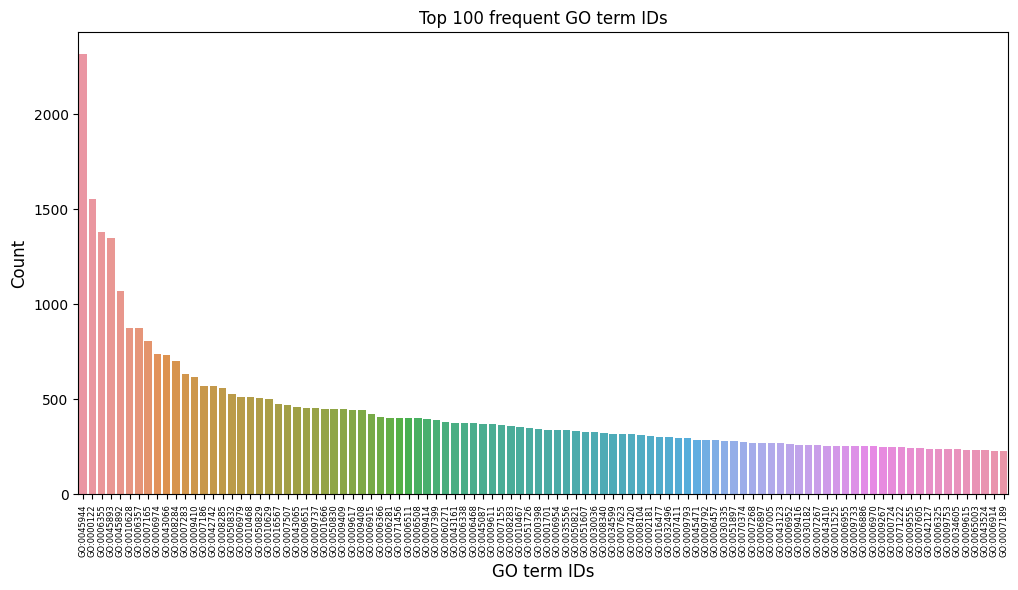

In [19]:
plot_df = dd.sql("select term, count(1) as freq from train_terms_w_embeds_bp group by term order by count(1) desc limit 100").pl()
plot_df_pandas = plot_df.to_pandas()

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=plot_df_pandas.term, y=plot_df_pandas.freq)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

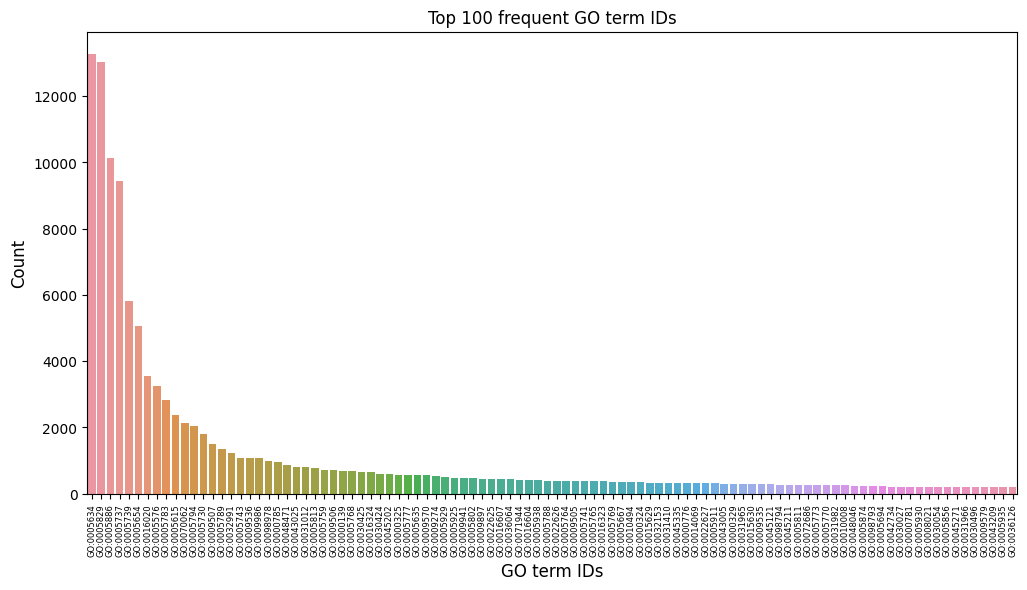

In [20]:
plot_df = dd.sql("select term, count(1) as freq from train_terms_w_embeds_cc group by term order by count(1) desc limit 100").pl()
plot_df_pandas = plot_df.to_pandas()

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=plot_df_pandas.term, y=plot_df_pandas.freq)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

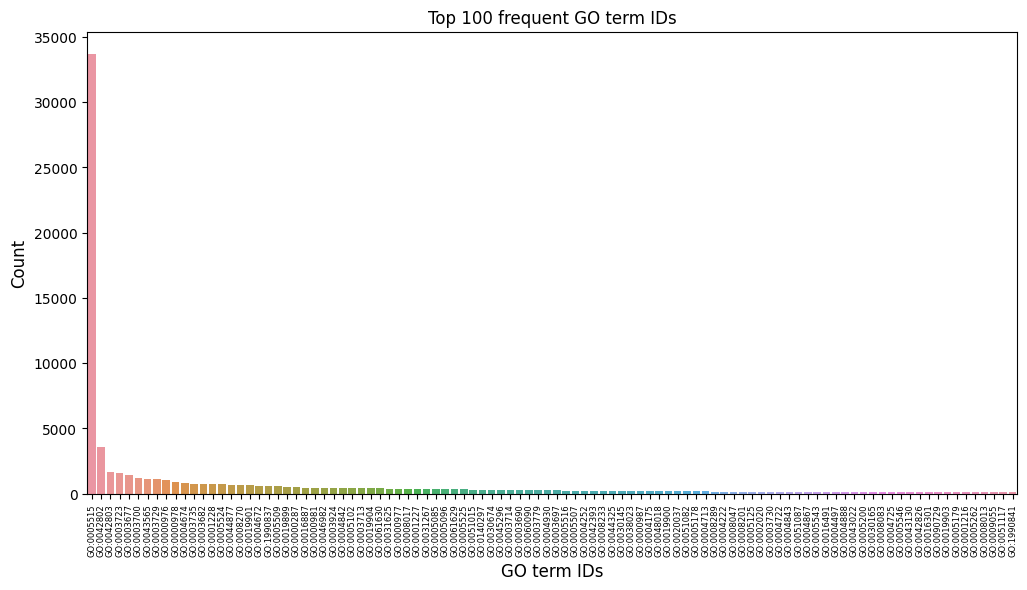

In [21]:
plot_df = dd.sql("select term, count(1) as freq from train_terms_w_embeds_mf group by term order by count(1) desc limit 100").pl()
plot_df_pandas = plot_df.to_pandas()

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=plot_df_pandas.term, y=plot_df_pandas.freq)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [20]:
from typing import List

num_of_labels = 1500

def train_labels_per_ontology_pl(input_df: pl.DataFrame, input_num_of_labels: int) -> pl.DataFrame:
    """
    Filters a Polars DataFrame to include only the top N most frequent terms.
    
    Args:
        input_df: The input Polars DataFrame with a 'term' column.
        input_num_of_labels: The number of top terms to keep.
        
    Returns:
        A new Polars DataFrame containing only the top N frequent labels.
    """

    # 1. Calculate the top N frequent terms using Polars methods
    top_labels_df = input_df.group_by("term").count().sort("count", descending=True).limit(input_num_of_labels)
    
    # 2. Extract these top terms into a Python list
    labels_list: List[str] = top_labels_df["term"].to_list()
    
    # 3. Filter the original DataFrame to keep only those terms
    train_labels = input_df.filter(pl.col("term").is_in(labels_list))
    
    print(f"Shape of filtered training data: {train_labels.shape}")
    print("Head of filtered training data:")
    print(train_labels.head())

    return train_labels


In [21]:
train_terms_bp = train_labels_per_ontology_pl(train_terms_w_embeds_bp, num_of_labels)
train_terms_cc = train_labels_per_ontology_pl(train_terms_w_embeds_cc, num_of_labels)
train_terms_mf = train_labels_per_ontology_pl(train_terms_w_embeds_mf, num_of_labels)

/tmp/ipykernel_38/2248799008.py:18: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  top_labels_df = input_df.group_by("term").count().sort("count", descending=True).limit(input_num_of_labels)


Shape of filtered training data: (143554, 4)
Head of filtered training data:
shape: (5, 4)
┌──────────────────────┬────────────┬────────┬─────────────────────────────────┐
│ protein_accession_id ┆ term       ┆ aspect ┆ protein_embedding               │
│ ---                  ┆ ---        ┆ ---    ┆ ---                             │
│ str                  ┆ str        ┆ str    ┆ array[f32, 480]                 │
╞══════════════════════╪════════════╪════════╪═════════════════════════════════╡
│ Q86I44               ┆ GO:0050766 ┆ P      ┆ [-0.221191, 0.055481, … 0.0029… │
│ Q1G3U5               ┆ GO:0009630 ┆ P      ┆ [-0.196167, 0.095032, … -0.027… │
│ Q9W0G1               ┆ GO:0051898 ┆ P      ┆ [-0.077271, -0.010437, … -0.01… │
│ O35767               ┆ GO:0000122 ┆ P      ┆ [-0.145264, -0.046783, … -0.01… │
│ P01579               ┆ GO:0032735 ┆ P      ┆ [-0.156616, 0.023712, … 0.0810… │
└──────────────────────┴────────────┴────────┴─────────────────────────────────┘
Shape of filtered 

In [22]:
train_terms_cc.filter(pl.col('term') == 'GO:0000322')

protein_accession_id,term,aspect,protein_embedding
str,str,str,"array[f32, 480]"
"""Q9ES28""","""GO:0000322""","""C""","[-0.102844, -0.062439, … -0.040375]"
"""P70452""","""GO:0000322""","""C""","[-0.162231, 0.055878, … -0.112305]"
"""P60766""","""GO:0000322""","""C""","[-0.216187, 0.003998, … -0.043945]"
"""Q39649""","""GO:0000322""","""C""","[-0.133057, 0.087402, … 0.004341]"
"""P63044""","""GO:0000322""","""C""","[-0.16333, -0.024521, … -0.039978]"


In [23]:
print(dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_terms_bp").pl())
print(dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_terms_cc").pl())
print(dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_terms_mf").pl())

shape: (1, 1)
┌────────────────────────────┐
│ uniq_protein_accession_ids │
│ ---                        │
│ i64                        │
╞════════════════════════════╡
│ 46861                      │
└────────────────────────────┘
shape: (1, 1)
┌────────────────────────────┐
│ uniq_protein_accession_ids │
│ ---                        │
│ i64                        │
╞════════════════════════════╡
│ 60036                      │
└────────────────────────────┘
shape: (1, 1)
┌────────────────────────────┐
│ uniq_protein_accession_ids │
│ ---                        │
│ i64                        │
╞════════════════════════════╡
│ 53461                      │
└────────────────────────────┘


In [24]:
train_protein_labels_bp = train_terms_bp.select(['protein_accession_id','term'])
print(train_protein_labels_bp.head(5))

train_protein_labels_cc = train_terms_cc.select(['protein_accession_id','term'])
print(train_protein_labels_cc.head(5))

train_protein_labels_mf = train_terms_mf.select(['protein_accession_id','term'])
print(train_protein_labels_mf.head(5))

shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str                  ┆ str        │
╞══════════════════════╪════════════╡
│ Q86I44               ┆ GO:0050766 │
│ Q1G3U5               ┆ GO:0009630 │
│ Q9W0G1               ┆ GO:0051898 │
│ O35767               ┆ GO:0000122 │
│ P01579               ┆ GO:0032735 │
└──────────────────────┴────────────┘
shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str                  ┆ str        │
╞══════════════════════╪════════════╡
│ Q9SHJ5               ┆ GO:0005739 │
│ Q9UUM2               ┆ GO:0005634 │
│ Q8C3Q5               ┆ GO:0099634 │
│ Q52KI8               ┆ GO:0005681 │
│ P01579               ┆ GO:0005576 │
└──────────────────────┴────────────┘
shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str   

In [25]:
train_protein_labels_cc.filter(pl.col('term') == 'GO:0000322')

protein_accession_id,term
str,str
"""Q9ES28""","""GO:0000322"""
"""P70452""","""GO:0000322"""
"""P60766""","""GO:0000322"""
"""Q39649""","""GO:0000322"""
"""P63044""","""GO:0000322"""


In [26]:
def get_pivoted_df(input_df: pl.DataFrame) -> pl.DataFrame:
    train_protein_labels_w_term_presence = input_df.with_columns(
        pl.lit(1.0).alias("presence")
    )

    pivoted_df = train_protein_labels_w_term_presence.pivot(
        index="protein_accession_id",
        on="term",
        values="presence",  
        aggregate_function="sum"
    )
    
    pivoted_df = pivoted_df.fill_null(0)
    print(pivoted_df.head(5))
    return pivoted_df

In [27]:
pivoted_df_bp = get_pivoted_df(train_protein_labels_bp)
pivoted_df_cc = get_pivoted_df(train_protein_labels_cc)
pivoted_df_mf = get_pivoted_df(train_protein_labels_mf)

shape: (5, 1_501)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ protein_a ┆ GO:005076 ┆ GO:000963 ┆ GO:005189 ┆ … ┆ GO:001622 ┆ GO:004814 ┆ GO:005171 ┆ GO:00351 │
│ ccession_ ┆ 6         ┆ 0         ┆ 8         ┆   ┆ 6         ┆ 9         ┆ 5         ┆ 96       │
│ id        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ ---       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
│ str       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Q86I44    ┆ 1.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ Q1G3U5    ┆ 0.0       ┆ 1.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ Q9W0G1    ┆ 0.0       ┆ 0.0       ┆ 1.0       ┆ … ┆ 0.0       ┆ 0.0    

In [29]:
pivoted_df_cc.group_by(['GO:0000322']).agg(pl.col("protein_accession_id").count())\
.filter(pl.col('GO:0000322')==1.0)

GO:0000322,protein_accession_id
f64,u32
1.0,5


In [30]:
print(pivoted_df_bp.shape)
print(pivoted_df_cc.shape)
print(pivoted_df_mf.shape)

(46861, 1501)
(60036, 1501)
(53461, 1501)


In [31]:
train_protein_features_bp = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_bp").pl()
print(train_protein_features_bp.head(5))

train_protein_features_cc = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_cc").pl()
print(train_protein_features_cc.head(5))

train_protein_features_mf = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_mf").pl()
print(train_protein_features_mf.head(5))

shape: (5, 2)
┌──────────────────────┬─────────────────────────────────┐
│ protein_accession_id ┆ protein_embedding               │
│ ---                  ┆ ---                             │
│ str                  ┆ array[f32, 480]                 │
╞══════════════════════╪═════════════════════════════════╡
│ Q61730               ┆ [-0.116333, 0.082581, … 0.0166… │
│ Q925U2               ┆ [-0.052582, -0.110596, … -0.02… │
│ P09544               ┆ [-0.167969, -0.029388, … 0.031… │
│ Q9VC57               ┆ [-0.075684, -0.073608, … -0.00… │
│ Q9H9V4               ┆ [-0.153198, 0.00272, … 0.08032… │
└──────────────────────┴─────────────────────────────────┘
shape: (5, 2)
┌──────────────────────┬─────────────────────────────────┐
│ protein_accession_id ┆ protein_embedding               │
│ ---                  ┆ ---                             │
│ str                  ┆ array[f32, 480]                 │
╞══════════════════════╪═════════════════════════════════╡
│ Q9SGE0               ┆ [-0

In [30]:
pivoted_df_mf.write_parquet('train_protein_labels_mf.parquet')
train_protein_features_mf.write_parquet('train_protein_features_mf.parquet')

pivoted_df_cc.write_parquet('train_protein_labels_cc.parquet')
train_protein_features_cc.write_parquet('train_protein_features_cc.parquet')

pivoted_df_bp.write_parquet('train_protein_labels_bp.parquet')
train_protein_features_bp.write_parquet('train_protein_features_bp.parquet')

In [31]:
test_prot_ids = [seq_record.id 
                 for seq_record in 
                 SeqIO.parse("/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta", "fasta")]

In [32]:
test_emb_df = pl.read_parquet('/kaggle/input/cafa6-protein-go-terms-feat-labels/test_protein_features_esm2_480.parquet')
test_emb_df.shape

(224309, 2)

In [33]:
test_embeds = test_emb_df.filter(pl.col("protein_accession_id").is_in(test_prot_ids))
test_embeds.shape

(224309, 2)

In [34]:
test_emb_df.head(4)

protein_accession_id,embedding_arrays
str,"array[f32, 480]"
"""Q8LX40""","[-0.194824, -0.071106, … -0.339844]"
"""Q8MHW5""","[-0.164673, 0.078003, … -0.00169]"
"""O00257""","[-0.026779, -0.084534, … -0.02684]"
"""A4FUD9""","[-0.067444, -0.020065, … 0.046936]"


In [35]:
dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from test_embeds").pl()

uniq_protein_accession_ids
i64
224309
